# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

2024-05-16 23:34:59.219161: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# !jupyter nbconvert --to script ./src/montecosmo/tests/model_ELI.ipynb

## Import

In [3]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_mean, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_size=8*np.ones(3, dtype=int))
# config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int), fourier=True)
# config.update(a_lpt=0.1, mesh_size=64*np.ones(3, dtype=int), fourier=False)
config.update(a_lpt=0.1, mesh_size=256*np.ones(3, dtype=int), fourier=False)
model = partial(pmrsd_model, **config)
print_config(model)

# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_mean(model)))
fiduc_params = get_simulator(fiduc_model)(rng_seed=0)

# # # Chain init
# @jit
# @vmap
# def sample_init_chains(rng_key, scale_std):
#     params_ = seed(prior_model, rng_key)(**config)
#     init_params = get_param_fn(scale_std=scale_std, **config)(**params_)
#     return get_param_fn(**config)(inverse=True, **init_params)

# init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array([0]+6*[1/10]))
# init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), 
#                         get_param_fn(**config)(inverse=True, **fiduc_params), init_params_)
# pickle_dump(fiduc_params, save_dir+"fiduc_params_fourier.p")
# pickle_dump(init_params_, save_dir+"init_params_fourier_.p")

# Load fiducial and chain init params
# fiduc_params = pickle_load(save_dir+"fiduc_params.p")
# init_params_ = pickle_load(save_dir+"init_params_.p")
# fiduc_params = pickle_load(save_dir+"fiduc_params_pm.p")
# init_params_ = pickle_load(save_dir+"init_params_pm_.p")
# fiduc_params = pickle_load(save_dir+"fiduc_params_fourier.p")
# init_params_ = pickle_load(save_dir+"init_params_fourier_.p")

# Condition model on observables
obs_names = ['obs_mesh']
# obs_names = ['obs_mesh','Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)
param_fn = get_param_fn(**config)
# print(fiduc_params, init_params_)

# CONFIG
{'mesh_size': array([256, 256, 256]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.1, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0]}, 'fourier': False, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [2.5, 2.5, 2.5] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        1.25664 h/Mpc
mean_gxy_density: 0.016 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [14]:
logp_vfn = jit(vmap(logp_fn))

@jit
@vmap
def logdensity_k(value):
    return logp_fn(fiduc_params | value) # update component k

n = 4
full_value = tree_map(lambda x: jnp.broadcast_to(x, shape=(n, *jnp.shape(x))), fiduc_params)
value = {'b1_': jnp.broadcast_to(fiduc_params['b1_'], shape=(n))}
# value = {'Omega_m_': jnp.broadcast_to(fiduc_params['Omega_m_'], shape=(n))}

In [17]:
%%time
logp_vfn(full_value);

CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 2.7 s


In [18]:
%%time
logdensity_k(value);

CPU times: user 644 ms, sys: 727 µs, total: 645 ms
Wall time: 645 ms


In [4]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


In [5]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


## Run

In [41]:
init_params_one_ = tree_map(lambda x: x[2], init_params_)
# init_params_one_ = tree_map(lambda x: x[2], {'init_mesh_':init_params_['init_mesh_']})
print("logp: ",logp_fn(init_params_one_))

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


logp:  -759798.6


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


### MCLMC

In [5]:
# from jax.flatten_util import ravel_pytree
# def mult_tree(params, factor):
#     flat, deravel = ravel_pytree(params)
#     return deravel(flat * factor)

# last_state = pickle_load(save_dir+"HMC/HMC_ns256_x_nc8"+"_laststate20.p")
# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
# logdensity = lambda y : logp_fn(mult_tree(y, invmm**(.5)))
# transform = lambda y: mult_tree(y.position, invmm**(.5))

# init_pos = mult_tree(init_params_one_, invmm**(-.5))

In [135]:
import blackjax

def MCLMC_run(key, init_state, logdensity, n_samples, transform):
    init_key, tune_key, run_key = jr.split(key, 3)

    # # create an initial state for the sampler
    # initial_state = blackjax.mcmc.mclmc.init(
    #     position=init_state, logdensity_fn=logdensity, rng_key=init_key
    # )

    # # build the kernel
    # kernel = blackjax.mcmc.mclmc.build_kernel(
    #     logdensity_fn=logdensity,
    #     integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    # )

    #####
    # # find values for L and step_size
    # tunning = blackjax.adaptation.mclmc_adaptation.mclmc_find_L_and_step_size(
    #     mclmc_kernel=kernel,
    #     num_steps=n_samples,
    #     state=initial_state,
    #     rng_key=tune_key,
    #     num_effective_samples=1024,
    # )
    # state_after_tuning, mclmc_sampler_params = tunning
    # L = mclmc_sampler_params.L
    # step_size = mclmc_sampler_params.step_size
    # initial_state = state_after_tuning
    #####

    L = 25
    step_size = 2
    initial_state = init_state

    # if not isinstance(initial_state, blackjax.mcmc.integrators.IntegratorState):
    #     from jax import debug
    #     debug.print("rep")
    #     initial_state = mult_tree(initial_state, invmm**(-.5))
    # tunning = (initial_state, {'L':L, 'step_size':step_size})


    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity,
        L=L,
        step_size=step_size,
    )

    # run the sampler
    last_state, samples, info = blackjax.util.run_inference_algorithm(
        rng_key = run_key,
        initial_state_or_position = initial_state,
        inference_algorithm = sampling_alg,
        num_steps = n_samples,
        transform = transform,
        progress_bar = True,
    )

    # Register only relevant infos
    infos = {"num_steps":jnp.ones(n_samples)}
    return last_state, samples, infos

def get_MCLMC_run(logdensity, n_samples, transform):
    return partial(MCLMC_run, 
                   logdensity = logdensity,
                   n_samples = n_samples,
                   transform = transform,)

In [136]:
logdensity = logp_fn
transform = lambda x: x.position
# n_samples, n_runs, n_chains = 3, 1, 8
n_samples, n_runs, n_chains = 256, 1, 2
save_path = save_dir + f"MCLMC__test7"

run_fn = jit(vmap(get_MCLMC_run(logdensity, n_samples, transform=transform)))
key = jr.key(42)
# last_state = init_params_
last_state = tree_map(lambda x: x[:n_chains], init_params_)

for i_run in range(1, n_runs+1):
    print(f"run {i_run}/{n_runs}")
    key, run_key = jr.split(key, 2)
    last_state, samples, infos = run_fn(jr.split(run_key, n_chains), last_state)
    samples = tree_map(lambda x: x[:,::2], samples)
    infos = tree_map(lambda x: 2*x[:,::2], infos)
    pickle_dump(samples | infos, save_path+f"_{i_run}.p")
    pickle_dump(last_state, save_path+f"_laststate.p")

run 1/1


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

### HMCGibbs

In [5]:
# from jax.flatten_util import ravel_pytree
# def mult_tree(params, factor):
#     flat, deravel = ravel_pytree(params)
#     return deravel(flat * factor)

# last_state = pickle_load(save_dir+"HMC/HMC_ns256_x_nc8"+"_laststate20.p")
# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
# logdensity = lambda x : logp_fn(mult_tree(x, invmm**.5))
# init_pos = mult_tree(init_params_one_, invmm**(-.5))

In [43]:
import blackjax
import blackjax.progress_bar

def mwg_warmup(rng_key, state, logdensity_fn, parameters, n_samples=0):
    rng_keys = jr.split(rng_key, num=len(state))
    rng_keys = dict(zip(state.keys(), rng_keys))

    # avoid modifying argument state as JAX functions should be pure
    state = state.copy()
    infos = {}
    infos['num_steps'] = 0
    params = {}
    positions = {}

    for k in state.keys():
        # logdensity of component k conditioned on all other components in state
        union = {}
        for _k in state.keys():
            union |= state[_k].position

        def logdensity_k(value):
            return logdensity_fn(union | value) # update component k

        # give state[k] the right log_density NOTE: unnecessary if we only pass position to warmup
        # state[k] = init_fn[k](
        #     position=state[k].position,
        #     logdensity_fn=logdensity_k
        # )

        wind_adapt = blackjax.window_adaptation(blackjax.nuts, logdensity_k, **parameters[k])
        rng_keys[k], warmup_key = jr.split(rng_keys[k], 2)
        (state[k], params[k]), info = wind_adapt.run(warmup_key, state[k].position, num_steps=n_samples)

        # register only relevant infos
        num_steps = info.info.num_integration_steps
        infos['infos_'+k] = {"acceptance_rate": info.info.acceptance_rate, 
                                "num_integration_steps": num_steps}
        infos['num_steps'] += num_steps
        # positions[k] = info.state.position
        positions |= info.state.position
    
    return (state, params), (positions, infos)



def mwg_kernel_general(rng_key, state, logdensity_fn, step_fn, init_fn, parameters):
    """
    General MWG kernel.

    Updates each component of ``state`` conditioned on all the others using a component-specific MCMC algorithm

    Parameters
    ----------
    rng_key
        The PRNG key.
    state
        Dictionary where each item is the state of an MCMC algorithm, i.e., an object of type ``AlgorithmState``.
    logdensity_fn
        The log-density function on all components, where the arguments are the keys of ``state``.
    step_fn
        Dictionary with the same keys as ``state``,
        each element of which is an MCMC stepping functions on the corresponding component.
    init
        Dictionary with the same keys as ``state``,
        each elemtn of chi is an MCMC initializer corresponding to the stepping functions in `step_fn`.
    parameters
        Dictionary with the same keys as ``state``, each of which is a dictionary of parameters to
        the MCMC algorithm for the corresponding component.

    Returns
    -------
    Dictionary containing the updated ``state``.
    """
    rng_keys = jr.split(rng_key, num=len(state))
    rng_keys = dict(zip(state.keys(), rng_keys))

    # avoid modifying argument state as JAX functions should be pure
    state = state.copy()
    infos = {}
    infos['num_steps'] = 0

    for k in state.keys():
        # logdensity of component k conditioned on all other components in state
        union = {}
        for _k in state.keys():
            union |= state[_k].position

        def logdensity_k(value):
            return logdensity_fn(union | value) # update component k
        
        # give state[k] the right log_density
        state[k] = init_fn[k](
            position=state[k].position,
            logdensity_fn=logdensity_k
        )

        # update state[k]
        state[k], info = step_fn[k](
            rng_key=rng_keys[k],
            state=state[k],
            logdensity_fn=logdensity_k,
            **parameters[k]
        )

        # register only relevant infos
        num_steps = info.num_integration_steps
        infos['infos_'+k] = {"acceptance_rate": info.acceptance_rate, 
                                "num_integration_steps": num_steps}
        infos['num_steps'] += num_steps
    
        return state, infos
    



def sampling_loop_general(rng_key, initial_state, logdensity_fn, step_fn, init_fn, parameters, n_samples):
    
    @blackjax.progress_bar.progress_bar_scan(n_samples)
    def one_step(state, xs):
        _, rng_key = xs
        state, infos = mwg_kernel_general(
            rng_key=rng_key,
            state=state,
            logdensity_fn=logdensity_fn,
            step_fn=step_fn,
            init_fn=init_fn,
            parameters=parameters
        )
        # positions = {k: state[k].position for k in state.keys()}
        union = {}
        for _k in state.keys():
            union |= state[_k].position
        # union = mult_tree(union, invmm**.5)
        return state, (union, infos)

    keys = jr.split(rng_key, n_samples)
    xs = (jnp.arange(n_samples), keys)
    last_state, (positions, infos) = lax.scan(one_step, initial_state, xs) # scan compile

    return last_state, (positions, infos)




def HMCGibbs_init(logdensity, kernel="hmc"):

    if kernel == "hmc":
        ker_api = blackjax.hmc
        parameters = {
            "mesh_": {
                # "inverse_mass_matrix": jnp.ones(64**3),
                "num_integration_steps": 256,
                # "step_size": 3*1e-3
            },
            "rest_": {
                # "inverse_mass_matrix": jnp.ones(6),
                "num_integration_steps": 64,
                # "step_size": 3*1e-3
            }
        }
    elif kernel == "nuts":
        ker_api = blackjax.nuts
        parameters = {
            "mesh_": {
                # "inverse_mass_matrix": jnp.ones(64**3),
                # "step_size": 3*1e-3
            },
            "rest_": {
                # "inverse_mass_matrix": jnp.ones(6),
                # "step_size": 3*1e-3
            }
        }
    mwg_init_x = ker_api.init
    mwg_init_y = ker_api.init
    mwg_step_fn_x = ker_api.build_kernel()
    mwg_step_fn_y = ker_api.build_kernel()

    step_fn = {
        "mesh_": mwg_step_fn_x,
        "rest_": mwg_step_fn_y
    }

    init_fn={
        "mesh_": mwg_init_x,
        "rest_": mwg_init_y
    }


    def init_state_fn(init_pos):
        return get_init_state(init_pos, logdensity, init_fn)


    return step_fn, init_fn, parameters, init_state_fn


def get_init_state(init_pos, logdensity, init_fn):
    init_pos_block1 = {name:init_pos[name] for name in ['init_mesh_']}
    init_pos_block2 = {name:init_pos[name] for name in ['Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_']}
    init_state = {
        "mesh_": init_fn['mesh_'](
            position = init_pos_block1,
            logdensity_fn = lambda x: logdensity(x |init_pos_block2)
        ),
        "rest_": init_fn['rest_'](
            position = init_pos_block2,
            logdensity_fn = lambda y: logdensity(y | init_pos_block1)
        )
    }
    return init_state


def HMCGibbs_run(rng_key, init_state, logdensity, step_fn, init_fn, parameters, n_samples, warmup=True):
    if warmup:
        (last_state, parameters), (samples, infos) = mwg_warmup(rng_key, init_state, logdensity, parameters, n_samples)
        return (last_state, parameters), samples, infos

    else:
        last_state, (samples, infos) = sampling_loop_general(
        rng_key = rng_key,
        initial_state = init_state,
        logdensity_fn = logdensity,
        step_fn = step_fn,
        init_fn = init_fn,
        parameters = parameters,
        n_samples = n_samples,)
        return last_state, samples, infos


def get_HMCGibbs_run(logdensity, step_fn, init_fn, parameters, n_samples, warmup=0):
    return partial(HMCGibbs_run, 
                   logdensity=logdensity, 
                   step_fn=step_fn, 
                   init_fn=init_fn, 
                   parameters=parameters, 
                   n_samples=n_samples,
                   warmup=warmup)

In [44]:
logdensity = logp_fn
n_samples, n_runs, n_chains = 256, 20, 8
save_path = save_dir + f"NUTSGibbs_ns{n_samples:d}_x_nc{n_chains}"

step_fn, init_fn, parameters, init_state_fn = HMCGibbs_init(logdensity, "nuts")
warmup_fn = jit(vmap(get_HMCGibbs_run(logdensity, step_fn, init_fn, parameters, n_samples, warmup=True)))
key = jr.key(42)
# last_state = jit(vmap(init_state_fn))(init_params_)
last_state = pickle_load(save_dir+"NUTSGibbs/HMCGibbs_ns256_x_nc8_laststate32.p")


(last_state, parameters), samples, infos = warmup_fn(jr.split(jr.key(43), n_chains), last_state)
print(parameters,'\n=======\n')
pickle_dump(samples | infos, save_path+f"_{0}.p")
pickle_dump(last_state, save_path+f"_laststate.p")

run_fn = jit(vmap(get_HMCGibbs_run(logdensity, step_fn, init_fn, parameters, n_samples)))
i_shift = 0
for i_run in range(i_shift+1, i_shift+n_runs+1):
    print(f"run {i_run}/{n_runs}")
    key, run_key = jr.split(key, 2)
    # last_state, samples, infos = run_fn(jr.split(run_key, n_chains), last_state)
    last_state, samples, infos = run_fn(jr.split(run_key, n_chains), last_state, parameters=parameters)
    pickle_dump(samples | infos, save_path+f"_{i_run}.p")
    pickle_dump(last_state, save_path+f"_laststate.p")

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

### NUTS, HMC

In [108]:
# num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 20, 8
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 10, 4
# num_samples, max_tree_depth, n_runs, num_chains = 128, 10, 5, 4
num_samples, max_tree_depth, n_runs, num_chains = 64, 10, 5, 1

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
# save_path = save_dir + f"HMC_ns{num_samples:d}_x_nc{num_chains}_2"
# save_path = save_dir + f"NUTS_ns{num_samples:d}_x_nc{num_chains}_pm"
save_path = save_dir + f"HMCGibbs_ns{num_samples:d}_test"
# save_path = save_dir + f"NUTS_ns{num_samples:d}_test_fourier"

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    step_size=1e-4, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    trajectory_length= 1023 * 3*1e-3 / 4, # (2**max_tree_depth-1)*step_size_NUTS/(2 to 4), compare with default 2pi.
    )


def gibbs_fn(rng_key, gibbs_sites, hmc_sites):
    pass
hmcgibbs_kernel = numpyro.infer.HMCGibbs(hmc_kernel, 
                                         gibbs_fn=gibbs_fn, 
                                         mgibbs_sites=['Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_'])

# # Propose MALA step size based on [Chen+2019](http://arxiv.org/abs/1801.02309)
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=obs_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    # num_warmup=0,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)

last_state = pickle_load(save_dir+"HMC/HMC_ns256_x_nc8"+"_laststate20.p")
print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
mcmc.post_warmup_state = last_state
invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
invmm.min(),invmm.max(),invmm.mean(),invmm.std()

mean_acc_prob: [0.80803084 0.8386745  0.84253967 0.8379951  0.8344405  0.8271428
 0.78143317 0.7575976 ] 
ss: [0.00375209 0.00315573 0.00307721 0.00308172 0.0031482  0.00331903
 0.00426199 0.00456732]


(Array(8.273011e-05, dtype=float32),
 Array(3.428375, dtype=float32),
 Array(0.6296289, dtype=float32),
 Array(0.2411227, dtype=float32))

In [16]:
# mlflow.end_run()
# mlflow.start_run(run_name="HMC, ss=1e-3")
# mlflow.log_params(config)
# mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})
print(save_path)

{'n_runs': 10, 'num_samples': 128, 'max_tree_depth': 10, 'num_chains': 4}
/feynman/home/dphp//hs276503/scratch/pickles/HMC_ns128_test12


In [ ]:
# init_params_one_ = tree_map(lambda x: x[:num_chains], init_params_)
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
# mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_one_)
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_)
# mlflow.log_metric('halt',1)

## Analysis

In [13]:
def separate(samples, separ=['num_steps']):
    samples = samples.copy()
    samples2 = {name:samples.pop(name) for name in separ}
    return samples, samples2

def recombine(dic, block, block_name, rest=True, aggr_fn=jnp.stack):
    combined = {}
    if rest:
        dic = dic.copy()
        for b, bn in zip(block, block_name):
            combined[bn] = aggr_fn(jnp.stack([dic.pop(k) for k in b]))
        combined |= dic
    else:
        for b, bn in zip(block, block_name):
            combined[bn] = aggr_fn(jnp.stack([dic[k] for k in b]))
    return combined

def combine(moments, axis=0):
    moments, infos = separate(moments)
    moments = tree_map(lambda x: x.mean(axis=axis), moments)
    infos = tree_map(lambda x: x.sum(axis=axis), infos)
    return moments | infos

def get_moments(x_, axis=0):
    x_, infos = separate(x_)
    moments = tree_map(lambda x: jnp.stack([x, x**2], axis=2), vmap(vmap(param_fn))(**x_))
    return combine(moments | infos, axis=axis)

def choice_cells(x_, rng_key, n):
    x_, infos = separate(x_)
    x = vmap(vmap(param_fn))(**x_)
    name = 'init_mesh'
    init_mesh = x[name]
    x[name] = jr.choice(rng_key, init_mesh.reshape((*init_mesh.shape[:2],-1)), 
                         shape=(n,), replace=False, axis=2)
    return x | infos

## For Chains, ESS, GR
conc_axis = [1] # axis: run x chain x sample 
# var_names = None
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
transform = lambda x:x
load_chains_ = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

var_names = [name+'_' for name in config['prior_config']] + ['num_steps'] + ['init_mesh_']
transform = jit(partial(choice_cells, rng_key=jr.key(1), n=10))
load_chains = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

## For Errors
conc_axis = []
var_names = [name+'_' for name in config['prior_config']] + ['num_steps'] + ['init_mesh_']
transform = jit(partial(get_moments, axis=(1)))
load_moments = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

In [13]:
# load_path = save_dir + f"MCLMC/MCLMC_ns8192_x_nc8"
# load_path = save_dir + f"NUTSGibbs/HMCGibbs_ns256_x_nc8"
# load_path = save_dir + f"NUTS/NUTS_ns256_x_nc8"
load_path = save_dir + f"HMC/HMC_ns256_x_nc8"
start_run, end_run = 1,42

samples_ = load_chains_(load_path, start_run, end_run)
samples = load_chains(load_path, start_run, end_run)
# samples = jit(vmap(param_fn))(**samples_) | separate(samples_)[1]
moments = load_moments(load_path, start_run, end_run)
# TODO: modify to not do for loop but instead tree_map and first dim is sampler dim
# pickle_dump(combine(moments, axis=(0,1)), save_dir+"NUTS/NUTS_moments20.p")

# n_comb = 4
# for i in range(1,2):
#     start_run, end_run = 1+(i-1)*n_comb,i*n_comb
#     transform = lambda x: tree_map(lambda y : y[:,::n_comb], x)
#     var_names = None
#     samples_ = load_runs(load_path, start_run, end_run, var_names, conc_axis=[1], transform=transform, verbose=True)
#     pickle_dump(samples_, save_dir + f"HMC/HMC_ns1024_x_nc8_{i}.p")

loading: HMC_ns256_x_nc8, from run 1 to run 40 (included)
total n_samples: (8, 10240), total n_evals: [2099200 2498560 2560000 2549760 2498560 2375680 1853440 1720320]

loading: HMC_ns256_x_nc8, from run 1 to run 40 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

total n_samples: (8, 10240), total n_evals: [2099200 2498560 2560000 2549760 2498560 2375680 1853440 1720320]

loading: HMC_ns256_x_nc8, from run 1 to run 40 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (40, 8), total n_evals: [453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888]



### Chain


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.29      0.32   2671.62      1.00
        b1      0.97      0.03      0.97      0.93      1.02    562.21      1.01
        b2     -0.03      0.01     -0.03     -0.06     -0.01    930.58      1.01
       bn2     -0.61      0.35     -0.62     -1.18     -0.05   1218.86      1.01
       bs2      0.01      0.05      0.01     -0.07      0.10    907.39      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83    730.33      1.00



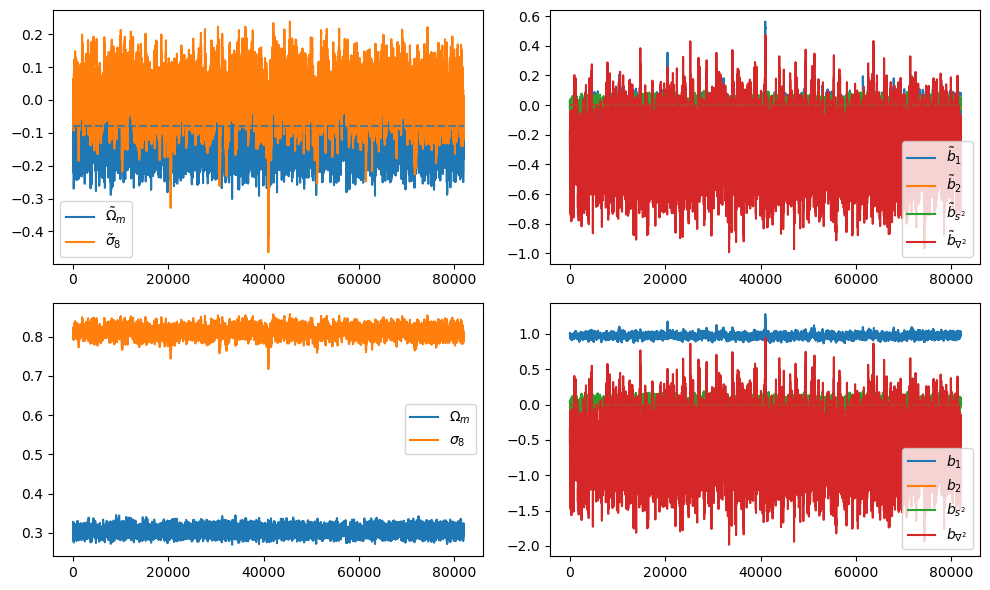

In [14]:
%matplotlib inline
def _plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\\tilde"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
# slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

def plot_chain(samples_:dict, prior_config:dict, fiduc:dict, verbose=True, **config):
    # Print diagnostics
    samples = jit(vmap(param_fn))(**samples_)
    if verbose:
        from numpyro.diagnostics import print_summary
        print_summary(samples, group_by_chain=True) # NOTE: group_by_chain if several chains

    # Concatenate and reparam chains
    samples_ = tree_map(lambda x: jnp.concatenate(x, axis=0), samples_)
    samples = tree_map(lambda x: jnp.concatenate(x, axis=0), samples)

    # Plot chains
    plot_fn = partial(_plot_chain, prior_config=prior_config, fiduc=fiduc)
    plt.figure(figsize=(10,6))
    plt.subplot(221)
    plot_fn({name:samples_[name] for name in ['Omega_m_','sigma8_']})
    plt.legend(), 
    plt.subplot(222)
    plot_fn({name:samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
    plt.legend(), 
    plt.subplot(223)
    plot_fn({name:samples[name] for name in ['Omega_m','sigma8']})
    plt.legend(), 
    plt.subplot(224)
    plot_fn({name:samples[name] for name in ['b1', 'b2','bs2','bn2']})
    plt.legend(), 
    plt.tight_layout()

# plot_chain(post_samples_[1], fiduc=fiduc_params, **config)
plot_chain(samples_, fiduc=fiduc_params, **config)
# mlflow.log_figure(plt.gcf(), f"MCLMC_chain_L25_ss2_invmm.svg")
plt.show();

In [14]:
from numpyro.diagnostics import effective_sample_size, gelman_rubin

def get_metric_traj(metric_fn, samples, n, axis=0, true=None):
    """
    """ # TODO: make such that no need to pass true, maybe by partial metrif_fn?
    samples, infos = separate(samples)
    if true is not None:
        true, true_infos = separate(true)

    def get_fn_traj(fn, samples, *args):
        metrics = []
        length = samples.shape[axis]
        for i_filt in np.arange(length, 1, -length// n)[::-1]:
            filt = jnp.arange(i_filt)
            metrics.append(fn(samples.take(filt, axis=axis), *args))
        return jnp.stack(metrics)
    
    get_infos_traj = partial(get_fn_traj, lambda x: x.sum())
    infos_traj = tree_map(get_infos_traj, infos)
    get_metric_traj = partial(get_fn_traj, metric_fn)
    if true is not None:
        metric_traj = tree_map(get_metric_traj, samples, true)
    else:
        metric_traj = tree_map(get_metric_traj, samples)
    return metric_traj | infos_traj


def geomean(x, axis=None):
    return jnp.exp( jnp.log(x).mean(axis=axis) )
multi_ess_fn = lambda x: geomean(effective_sample_size(x))
def grmean(x, axis=None):
    """cf. https://arxiv.org/pdf/1812.09384"""
    return (1 + geomean(x**2 - 1, axis=axis) )**.5
multi_gr_fn = lambda x: grmean(gelman_rubin(x))
def multi_gr_fn2(x):
    n_chains = x.shape[0]
    return geomean(gelman_rubin(x)**2 - 1) / n_chains # about 1/N_eff

sqrerr_moments_fn = lambda m, m_true: (m.mean(axis=(0,1))-m_true)**2
@jit
def sqrerr_locscale_fn(moments, moments_true):
    # Get mean and std from runs and chains
    m1_hat, m2_hat = moments.mean(axis=(0,1))
    m1, m2 = moments_true
    std_hat, std = (m2_hat - m1_hat**2)**.5, (m2 - m1**2)**.5 # Huygens formula
    # Compute normalized errors
    err_loc, err_scale = (m1_hat - m1) / std, (std_hat - std) / (std / 2**.5) # asymptotically N(0, 1/n_eff)
    mse_loc, mse_scale = (err_loc**2).mean(), (err_scale**2).mean() # asymptotically 1/n_eff * Chi^2(d)/d
    return jnp.stack([mse_loc, mse_scale])

@jit
def sqrerr_locscale_fn2(moments, moments_true):
    # Get mean and std from runs
    n_chains = moments.shape[1]
    m_hat = moments.mean(axis=(0))
    m1_hat, m2_hat = m_hat[:,0], m_hat[:,1]
    m1, m2 = moments_true
    std_hat, std = (m2_hat - m1_hat**2)**.5, (m2 - m1**2)**.5 # Huygens formula
    # Compute normalized errors
    err_loc, err_scale = (m1_hat - m1) / std, (std_hat - std) / (std / 2**.5) # asymptotically N(0, n_chain/n_eff)
    mse_loc, mse_scale = (err_loc**2).mean(), (err_scale**2).mean() # asymptotically n_chain/n_eff * Chi^2(d*n_chain)/(d*n_chain) 
    return jnp.stack([mse_loc, mse_scale]) / n_chains # asymptotically 1/n_eff * Chi^2(d*n_chain)/(d*n_chain) 

In [36]:
n_toplot = 100
# ESSs = get_metric_traj(effective_sample_size, samples, n_toplot, 1)
# GRs = get_metric_traj(gelman_rubin, samples, n_toplot, 1)
ESSs = get_metric_traj(multi_ess_fn, samples, n_toplot, 1)
# GRs = get_metric_traj(multi_gr_fn, samples, n_toplot, 1)
GRs = get_metric_traj(multi_gr_fn2, samples, n_toplot, 1)

moments_true = pickle_load(save_dir+"NUTS/NUTS_moments20.p")
# SEs = get_metric_traj(sqrerr_moments_fn, moments, n_toplot, 0, moments_true)
# NMSEs = get_metric_traj(sqrerr_locscale_fn, moments, n_toplot, 0, moments_true)
NMSEs = get_metric_traj(sqrerr_locscale_fn2, moments, n_toplot, 0, moments_true)

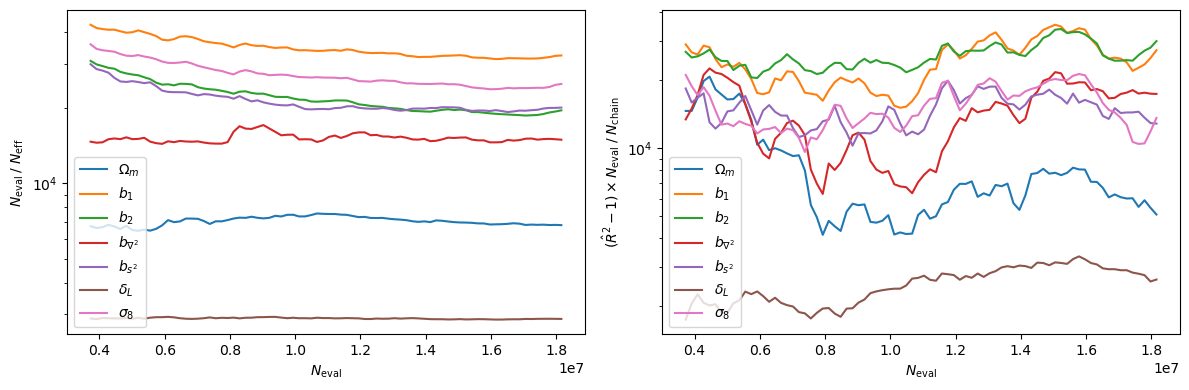

In [37]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj, infos_traj = separate(ESSs)
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

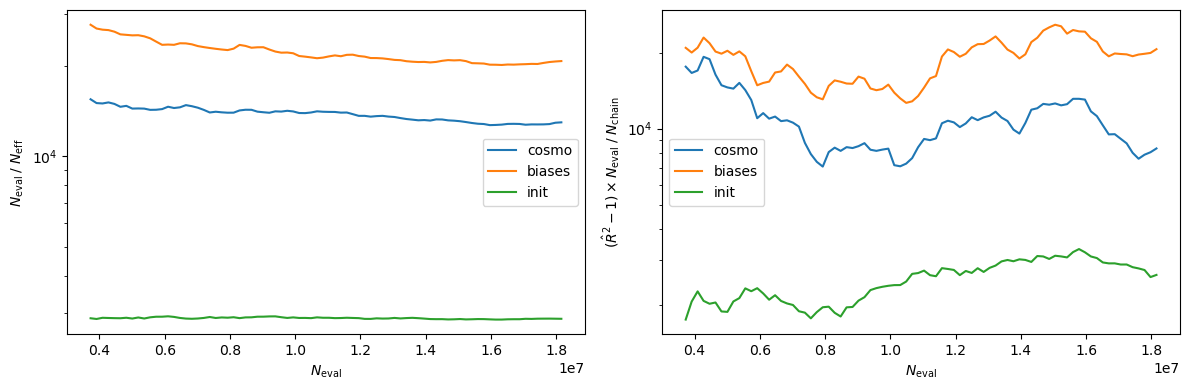

In [43]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(geomean, axis=0))
metric_traj, infos_traj = separate(ESSs)
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        # aggr_fn=partial(grmean, axis=0))
                        aggr_fn=partial(geomean, axis=0))
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

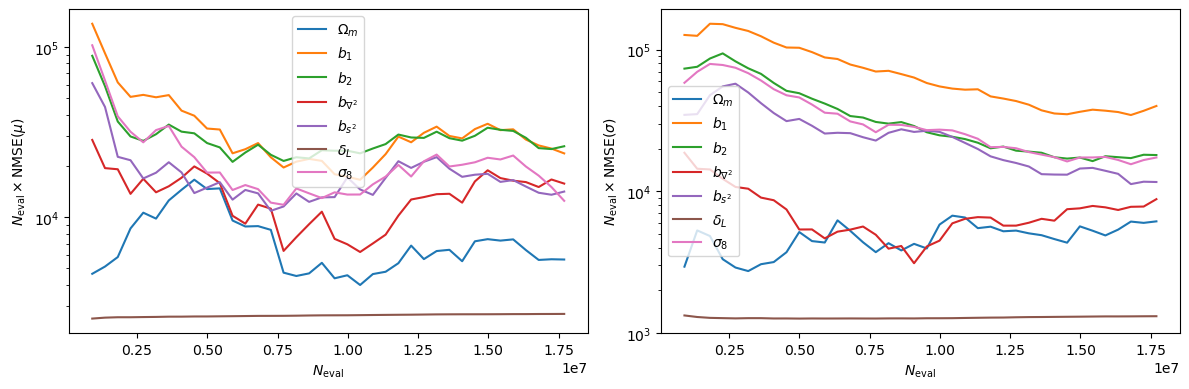

In [40]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :
    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        if name == 'init_mesh':
            label = "$\\delta_L$"
        else:
            label = '$'+config['prior_config'][name][0]+'$'
        plot_fn(val, label=label)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

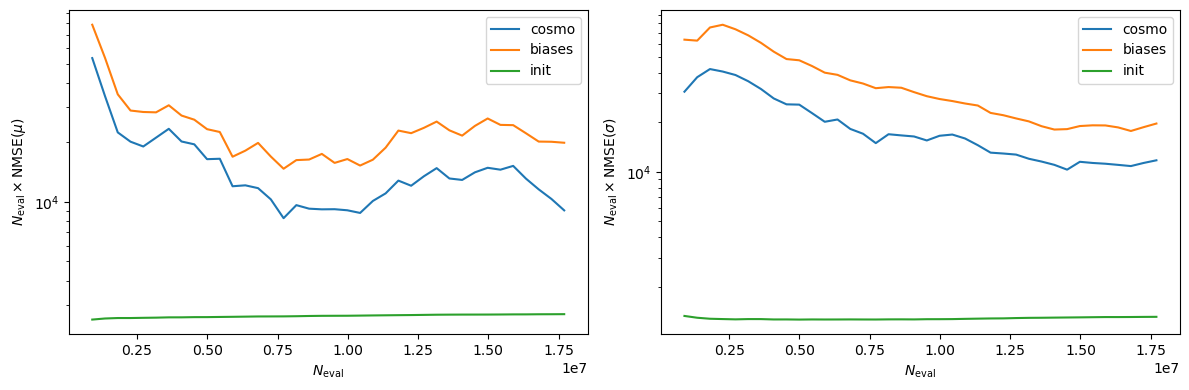

In [44]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(jnp.mean, axis=0))
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        plot_fn(val, label=name)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

## Multiple runs analysis

In [15]:
paths = ["HMC/HMC_ns256_x_nc8","NUTS/NUTS_ns256_x_nc8","NUTSGibbs/HMCGibbs_ns256_x_nc8"]
load_paths = np.array([os.path.join(save_dir, path) for path in paths])
mc_labels = ["HMC","NUTS",'NUTSGibbs']
start_run, end_run = [2,1,2], [64,20,32]
# start_run, end_run = [1,1,1], [5,5,5]

moments = load_moments(load_paths, start_run, end_run)

# samples_ = load_chains_(load_paths, start_run, end_run)
samples = load_chains(load_paths, start_run, end_run)
# samples = [jit(vmap(param_fn))(**s_) | separate(s_)[1] for s_ in samples_]

loading: HMC_ns256_x_nc8, from run 2 to run 64 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

total n_samples: (63, 8), total n_evals: [453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888 453888 453888 453888 453888 453888 453888 453888
 453888 453888 453888]

loading: NUTS_ns256_x_nc8, from run 1 to run 20 (included)
total n_samples: (20, 8), total n_evals: [2095104 2095104 2095104 2095104 2095104 2095104 2095104 2095104 2095104
 2095104 2095104 2095104 2095104 2095104 2095104 2095104 2095104 2095104
 2095104 2095104]

loading: HMCGibbs_ns256_x_nc8, from run 2 to run 32 (included)
total n_samples: (31, 8), total n_evals: [2142502 2143468 2142290 2143850 2142496 2141442 2141860 2143022 2141788
 2141678 2142480 2142380 2142494 2141190 2141402 2141840 2140572 21

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 16128), total n_evals: [3306240 3935232 4032000 4015872 3935232 3741696 2919168 2709504]

loading: NUTS_ns256_x_nc8, from run 1 to run 20 (included)
total n_samples: (8, 5120), total n_evals: [5237760 5237760 5237760 5237760 5237760 5237760 5237760 5237760]

loading: HMCGibbs_ns256_x_nc8, from run 2 to run 32 (included)
total n_samples: (8, 7936), total n_evals: [8300684 8304466 8304200 8303544 8299206 8299780 8300466 8298748]



In [17]:
from numpyro.diagnostics import print_summary
for lab, s in zip(mc_labels, samples):
    print(f"# {lab}")
    print_summary(separate(s)[0], group_by_chain=True) # NOTE: group_by_chain if several chains

# HMC

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.30      0.01      0.30      0.29      0.32   4126.13      1.00
          b1      0.97      0.03      0.97      0.92      1.02    810.88      1.01
          b2     -0.03      0.01     -0.03     -0.05     -0.01   1512.12      1.01
         bn2     -0.62      0.35     -0.63     -1.18     -0.04   1739.52      1.00
         bs2      0.01      0.05      0.01     -0.07      0.10   1297.34      1.01
init_mesh[0]     -0.59      0.80     -0.60     -1.95      0.70  10594.20      1.00
init_mesh[1]     -0.54      0.85     -0.54     -1.92      0.86  13746.39      1.00
init_mesh[2]     -0.22      0.84     -0.21     -1.59      1.16  12920.03      1.00
init_mesh[3]      0.76      0.77      0.75     -0.47      2.07   9727.48      1.00
init_mesh[4]      0.62      0.81      0.62     -0.71      1.95   7170.34      1.00
init_mesh[5]      0.17      0.78      0.16     -1.10      1.45   9801.91      1.

In [18]:
n_toplot = 200
ESSs = [get_metric_traj(multi_ess_fn, s, n_toplot, 1) for s in samples]
GRs = [get_metric_traj(multi_gr_fn2, s, n_toplot, 1) for s in samples]
moments_true = pickle_load(save_dir+"NUTS/NUTS_moments20.p")
# NMSEs = [get_metric_traj(sqrerr_locscale_fn, m, n_toplot, 0, moments_true) for m in moments]
NMSEs = [get_metric_traj(sqrerr_locscale_fn2, m, n_toplot, 0, moments_true) for m in moments]

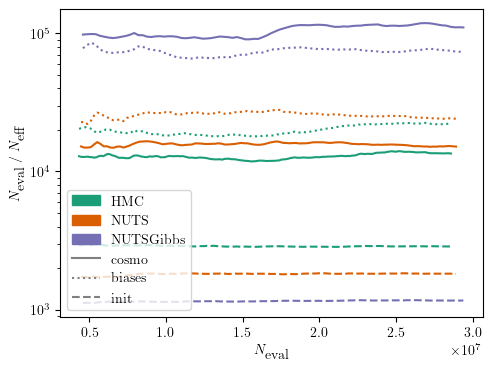

In [21]:
# sli_plot = slice(10,None)
# sli_plots = [slice(15,None), slice(10,68), slice(10,71)]
sli_plots = [slice(2*15,None), slice(2*10,2*68), slice(2*8,2*53)]
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']
recomb_cbi = partial(recombine, 
					 block=[['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
					 block_name=['cosmo','biases','init']) 

plt.figure(figsize=(12,4))
plt.subplot(121)
trajs = []
for m in ESSs: # TODO: modify to not do for loop but instead tree_map and first dim is sampler dim
    traj = recomb_cbi(m, aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)

theme_switch(usetex=True)
# plt.subplot(1, 2, 1)
for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles, loc="lower left")




# plt.subplot(1, 2, 2)
# trajs = []
# for m in GRs:
#     traj = recomb_cbi(m, 
#                     # aggr_fn=partial(grmean, axis=0))
#                       aggr_fn=partial(geomean, axis=0))
#     trajs.append(traj)

# for i_traj, traj in enumerate(trajs):
#     metrics, infos = separate(traj)
#     num_steps = infos['num_steps']
#     sli_plot = sli_plots[i_traj]

#     # plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
#     plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
#     for i_val, (name, val) in enumerate(metrics.items()):
#         plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# # plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
# from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# # handles, labels = plt.gca().get_legend_handles_labels()
# handles = []
# for i_traj in range(len(trajs)):
#     handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
# for i_val, name in enumerate(metrics):
#     handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
# plt.legend(handles=handles)
# plt.tight_layout()
# plt.savefig('ess_traj.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

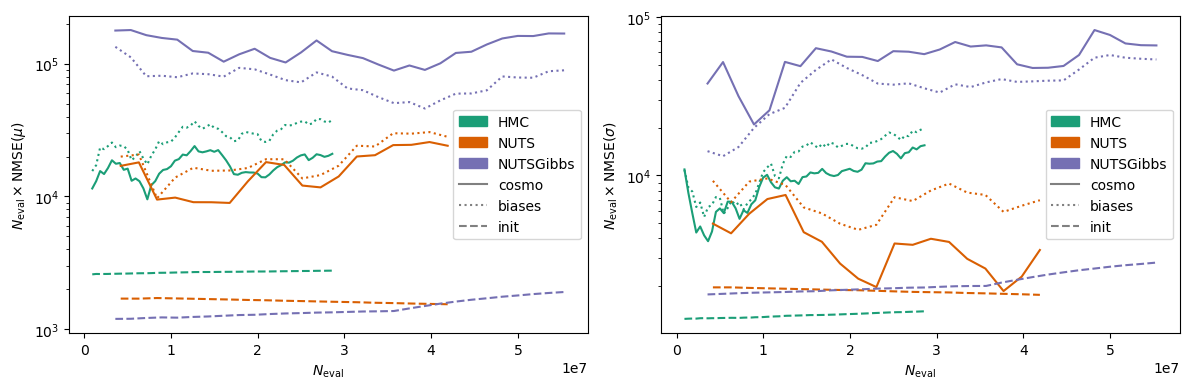

In [64]:
sli_plot = slice(0,None)
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']

trajs = []
for m in NMSEs:
    traj = recomb_cbi(m, aggr_fn=partial(jnp.mean, axis=0))
    trajs.append(traj)

plt.figure(figsize=(12,4))
for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    # markers = ['+','^']
    plt.subplot(1, 2, i_plot+1)
    markers = 2*[None]

    for i_traj, traj in enumerate(trajs):
        metrics, infos = separate(traj)
        num_steps = infos['num_steps']
        # if i_traj ==2: print(num_steps)

        plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
        for i_val, (name, val) in enumerate(metrics.items()):
            plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val], marker=markers[i_plot])

    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    # handles, labels = plt.gca().get_legend_handles_labels()
    handles = []
    for i_traj in range(len(trajs)):
        handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
    for i_val, name in enumerate(metrics):
        handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
    plt.legend(handles=handles)
plt.tight_layout()
plt.show();

In [65]:
def get_first_after(dic, thres, verbose=False, mult=True):
	metrics, infos = separate(dic)
	num_steps = infos['num_steps']
	i_thres = (num_steps > thres).argmax(axis=0)
	ns = num_steps[i_thres]
	if verbose:
		print(f"relerr: {(ns - thres)/thres:.0e}")
	if mult:
		return tree_map(lambda x: ns * x[i_thres], metrics)
	else:
		return tree_map(lambda x: ns / x[i_thres], metrics)


# thres = 2.8*1e7
thres = 2.5*1e7
ESS1 = [recomb_cbi(get_first_after(m, thres, True, False), aggr_fn=partial(geomean, axis=0)) for m in ESSs]
NMSE1 = [recomb_cbi(get_first_after(m, thres, True), aggr_fn=partial(jnp.mean, axis=0)) for m in NMSEs]
metric1 = [tree_map(lambda x,y: jnp.concatenate((x[None], y)), m1, m2) for m1, m2 in zip(ESS1, NMSE1)]

relerr: 6e-03
relerr: 1e-02
relerr: 9e-03
relerr: 2e-02
relerr: 6e-03
relerr: 7e-02


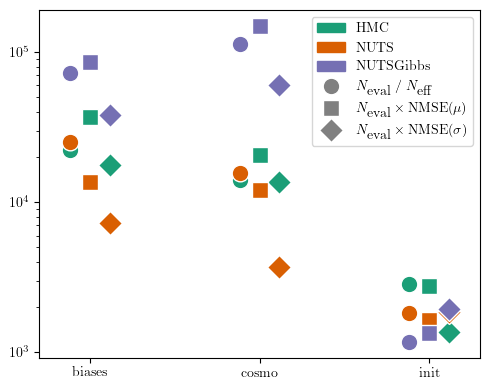

In [96]:
plt.figure(figsize=(5,4))
colors = [plt.get_cmap('Dark2')(i/7) for i in range(len(mc_labels))]
markers = ['o','s','D']
ls = ""
alpha = 1
# ms = 10
# mec = None
ms = 12
mec = 'w'
from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData



usetex = True
theme_switch(usetex=usetex)
for i_mc, (label, mets) in enumerate(zip(mc_labels, metric1)):
    for i_met in range(3):
        # block_names = ['cosmo','biases','init']
        block_names = ['biases','cosmo','init']
        # block_names_lat = ["$\\textrm{biases}$",'$\\textrm{cosmo}$','$\\textrm{init}$']
        met = [mets[k][i_met] for k in block_names]
        if i_met == 0:
            ls = ""
        else:
            ls = ""
        xshifts = 5*np.array([-1,0,1])
        # xshifts = *np.array([0,0,0])
        plt.semilogy(block_names, met, color=colors[i_mc], marker=markers[i_met], 
                     linestyle=ls, alpha=alpha, markersize=ms, markeredgecolor=mec, transform=trans+offset(xshifts[i_met]))

plt.xlim(-.3,2.3), plt.ylim((917, 190842))
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# # handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(mc_labels)):
    # mc_labels_lat = ["$\\textrm{NUTS}$","$\\textrm{HMC}$","$\\textrm{HMCGibbs}$"]
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
if not usetex:
    metric_names = ["$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\mu)$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\sigma)$"]
else:
    metric_names = ["$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\mu)$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\sigma)$"]
for i_met, name in enumerate(metric_names):
    handles.append(Line2D([], [], color='grey', marker=markers[i_met], linestyle=ls, label=name, alpha=alpha, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.savefig('benchmark.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

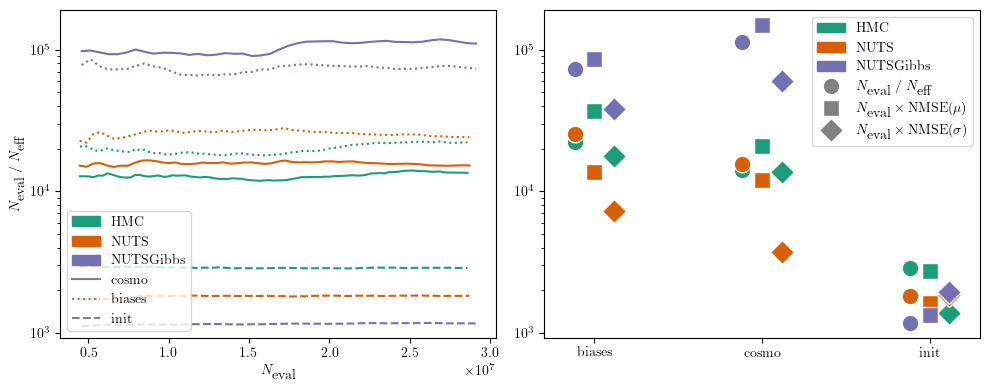

In [97]:
# sli_plot = slice(10,None)
# sli_plots = [slice(15,None), slice(10,68), slice(10,71)]
sli_plots = [slice(15,None), slice(10,68), slice(8,53)]
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']
recomb_cbi = partial(recombine, 
					 block=[['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
					 block_name=['cosmo','biases','init']) 

plt.figure(figsize=(10,4))

plt.subplot(121)



trajs = []
for m in ESSs: # TODO: modify to not do for loop but instead tree_map and first dim is sampler dim
    traj = recomb_cbi(m, aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)


# plt.subplot(1, 2, 1)
for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles, loc="lower left")
plt.ylim((917, 190842))



plt.subplot(122)
colors = [plt.get_cmap('Dark2')(i/7) for i in range(len(mc_labels))]
markers = ['o','s','D']
ls = ""
alpha = 1
# ms = 10
# mec = None
ms = 12
mec = 'w'
from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData



usetex = True
theme_switch(usetex=usetex)
for i_mc, (label, mets) in enumerate(zip(mc_labels, metric1)):
    for i_met in range(3):
        # block_names = ['cosmo','biases','init']
        block_names = ['biases','cosmo','init']
        # block_names_lat = ["$\\textrm{biases}$",'$\\textrm{cosmo}$','$\\textrm{init}$']
        met = [mets[k][i_met] for k in block_names]
        if i_met == 0:
            ls = ""
        else:
            ls = ""
        xshifts = 5*np.array([-1,0,1])
        # xshifts = *np.array([0,0,0])
        plt.semilogy(block_names, met, color=colors[i_mc], marker=markers[i_met], 
                     linestyle=ls, alpha=alpha, markersize=ms, markeredgecolor=mec, transform=trans+offset(xshifts[i_met]))

plt.xlim(-.3,2.3), plt.ylim((917, 190842))
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# # handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(mc_labels)):
    # mc_labels_lat = ["$\\textrm{NUTS}$","$\\textrm{HMC}$","$\\textrm{HMCGibbs}$"]
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
if not usetex:
    metric_names = ["$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\mu)$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\sigma)$"]
else:
    metric_names = ["$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\mu)$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\sigma)$"]
for i_met, name in enumerate(metric_names):
    handles.append(Line2D([], [], color='grey', marker=markers[i_met], linestyle=ls, label=name, alpha=alpha, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.savefig('ess_bench.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

### Highest Density Regions

Removed no burn in
# NUTS
using 40960 rows, 6 parameters; mean weight 1.0, tot weight 40960.0
Equiv number of single samples (sum w)/max(w): 40960
Effective number of weighted samples (sum w)^2/sum(w^2): 40960


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.01      0.30      0.29      0.32   6360.43      1.00
        b1      0.98      0.03      0.98      0.92      1.03    989.02      1.00
        b2     -0.03      0.01     -0.03     -0.06     -0.01   1785.97      1.00
       bn2     -0.61      0.35     -0.61     -1.19     -0.03   2819.05      1.00
       bs2      0.02      0.05      0.02     -0.07      0.10   1775.21      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83   1168.15      1.00

Removed no burn in
# HMC
using 129024 rows, 6 parameters; mean weight 1.0, tot weight 129024.0
Equiv number of single samples (sum w)/max(w): 129024
Effective number of weighted samples (sum w)^2/sum(w^2): 129024


     

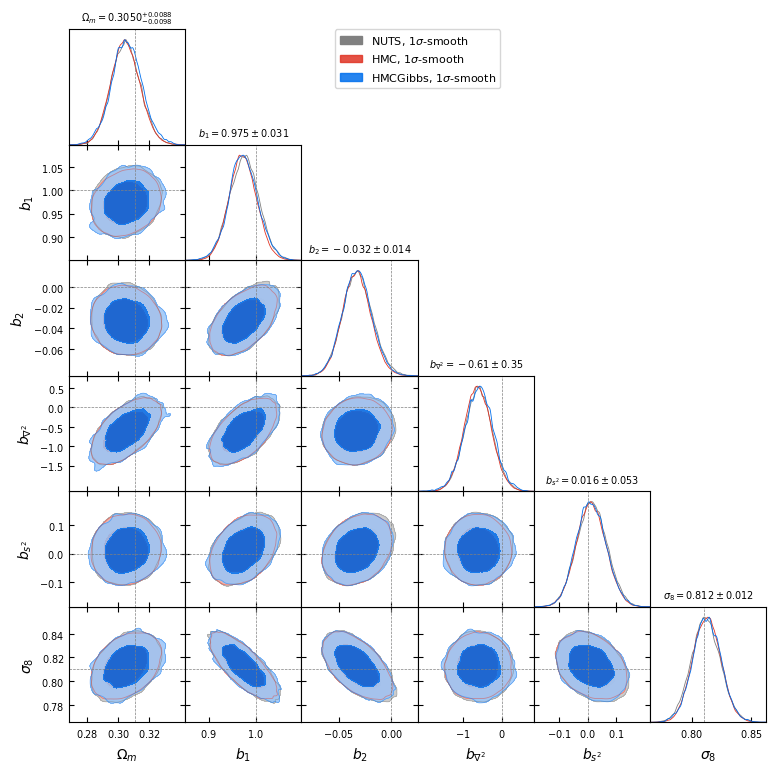

In [93]:
%matplotlib inline
from montecosmo.utils import get_gdsamples, get_gdprior

conc_samples = [tree_map(lambda x: jnp.concatenate(x, axis=0), separate(s, ['num_steps','init_mesh'])[0]) for s in samples]
gdsamples = get_gdsamples(conc_samples, label=mc_labels, verbose=True, **config)
for i_gds, gds in enumerate(gdsamples): 
    gdsamples[i_gds] = gds.copy(label=mc_labels[i_gds]+", 1$\\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})
# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))

g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r'
g.triangle_plot(roots=gdsamples, 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


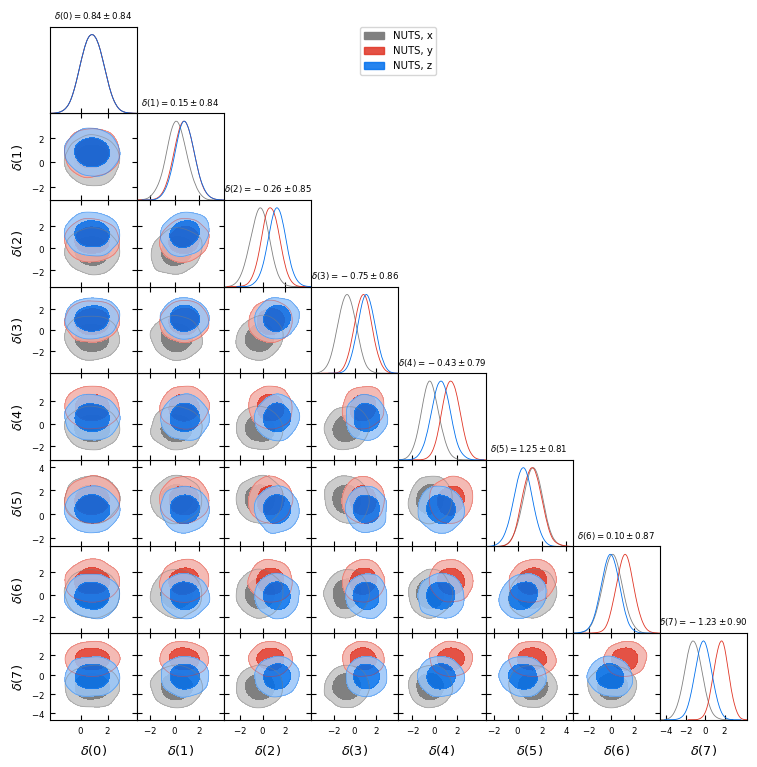

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [9]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(post_samples['init_mesh'])
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

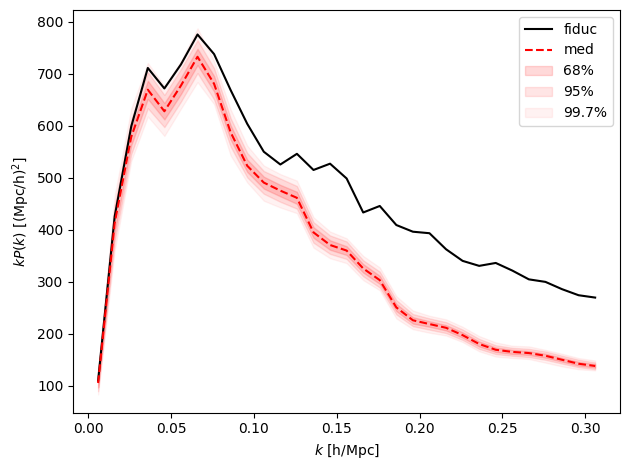

In [10]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

plot_fn(pk_fiduc, 'k', label='fiduc')
plot_fn(pk_5000, 'r--', label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color='red', label='68%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color='red', label='95%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color='red', label='99.7%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P(k)$ [(Mpc/h)$^2$]")
plt.legend()
plt.tight_layout()
# plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


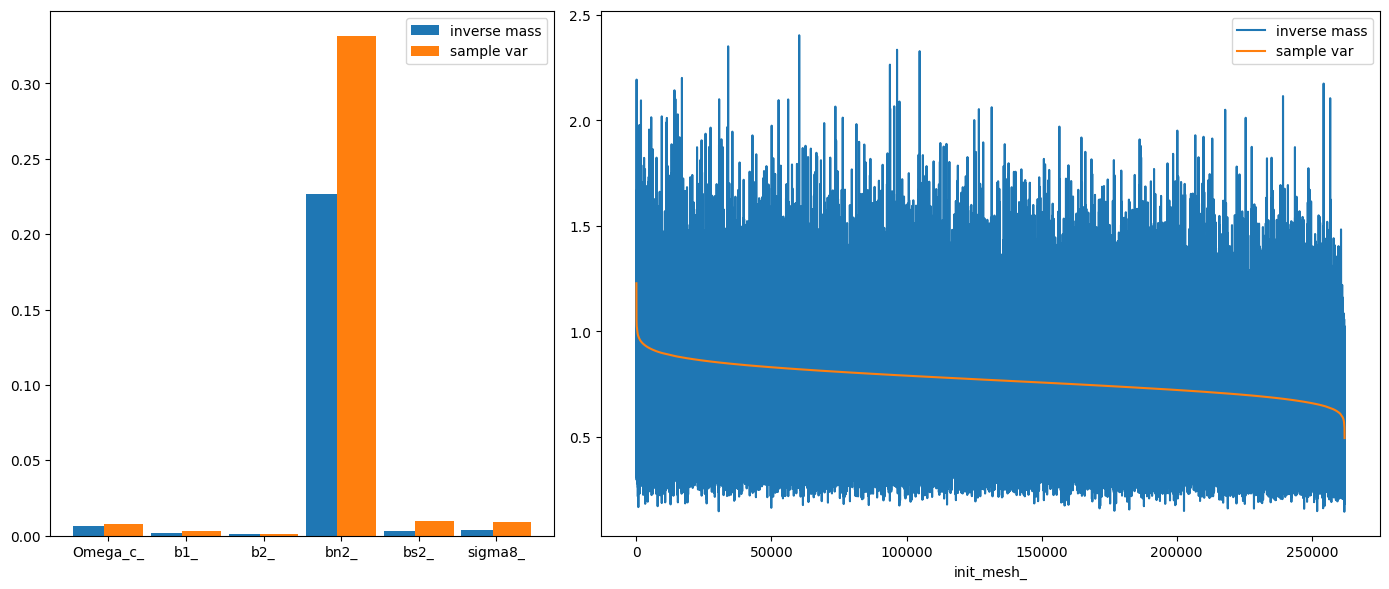

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = post_samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
plt.savefig(save_path+"_invMvar.svg");

In [ ]:
# # Save posterior variance as inverse mass matrix format
# post_variance = []
# for var_name in var_names:
#     if var_name == 'init_mesh_base':
#         var_name = 'init_mesh'
#         post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
#     else:
#         post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
#         post_variance = np.concatenate((post_variance, ))
# variance_as_invM = {var_names: post_variance}
# print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

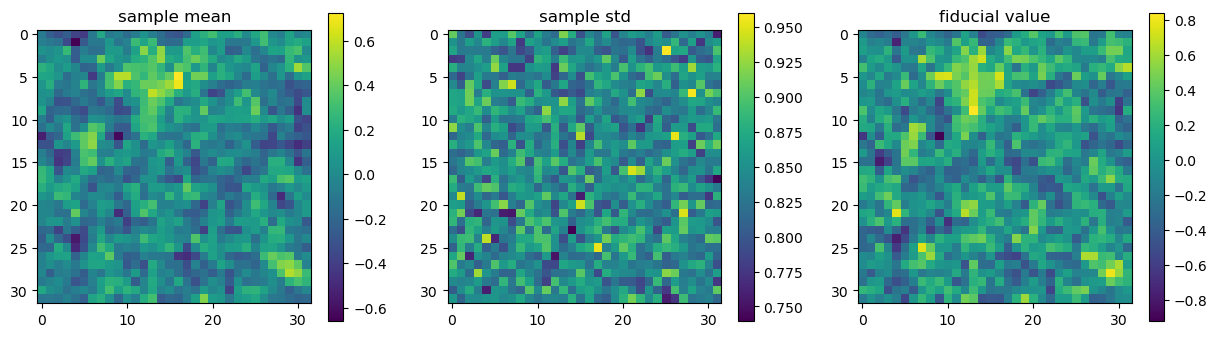

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();